# **Case Study 2.1**: 
For this case study, your task is to apply the data cleaning techniques previously covered on a modified version of the Health Insurance Dataset obtained from Kaggle (https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset). You can access the dataset in the **ENCS5141_Exp2_HealthInsurance.csv** file. This file is available in the GitHub repository hosted at https://github.com/mkjubran/ENCS5141Datasets.


## 1. Data cleaning

In [1]:
!rm -rf ./ENCS5141Datasets
!git clone https://github.com/mkjubran/ENCS5141Datasets.git

Cloning into 'ENCS5141Datasets'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 54 (delta 12), reused 44 (delta 5), pack-reused 0
Receiving objects: 100% (54/54), 2.97 MiB | 1.46 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.cluster import KMeans

In [176]:
df = pd.read_csv("../ENCS5141Datasets/ENCS5141_Exp2_HealthInsurance.csv")
df.head()

age     sex     bmi  children smoker     region      charges
0  19.0  female  27.900       0.0    yes  southwest  16884.92400
1  18.0    male  33.770       1.0     no  southeast   1725.55230
2  28.0    male  33.000       3.0     no  southeast   4449.46200
3  33.0    male  22.705       0.0     no  northwest  21984.47061
4  32.0    male  28.880       0.0     no  northwest   3866.85520

In [177]:
print(df.isnull().sum())
print(len(df))

age         12
sex         19
bmi         17
children    52
smoker      17
region       0
charges      0
dtype: int64
1338


For category columns, we must check all possible labels and dublicates

In [178]:
print(df['sex'].unique())
print(df['smoker'].unique())
print(df['region'].unique())

['female' 'male' nan]
['yes' 'no' nan]
['southwest' 'southeast' 'northwest' 'northeast']


In [209]:
df.duplicated().value_counts()

False    1338
Name: count, dtype: int64

In [179]:
df_copy = df.copy()

label_encoder = LabelEncoder()

df_copy['sex_encoded'] = label_encoder.fit_transform(df_copy['sex'])
df_copy['smoker_encoded'] = label_encoder.fit_transform(df_copy['smoker'])
df_copy['region_encoded'] = label_encoder.fit_transform(df_copy['region'])

df_copy.drop(['sex','smoker', 'region'],axis=1,inplace=True)

df_copy.corr()

age       bmi  children   charges  sex_encoded  \
age             1.000000  0.041396  0.047410  0.289503     0.009629   
bmi             0.041396  1.000000 -0.014421  0.095271     0.024692   
children        0.047410 -0.014421  1.000000  0.070550     0.005428   
charges         0.289503  0.095271  0.070550  1.000000     0.083854   
sex_encoded     0.009629  0.024692  0.005428  0.083854     1.000000   
smoker_encoded -0.024930 -0.009221  0.041956  0.706325     0.076778   
region_encoded  0.004752  0.093012  0.035776 -0.006208     0.010832   

                smoker_encoded  region_encoded  
age                  -0.024930        0.004752  
bmi                  -0.009221        0.093012  
children              0.041956        0.035776  
charges               0.706325       -0.006208  
sex_encoded           0.076778        0.010832  
smoker_encoded        1.000000       -0.006464  
region_encoded       -0.006464        1.000000

For the `smoker` column, there is a high correlation with the `charges` column. We plot the relation, we may set a threshold to separate the values or use the outcome distributions to detect the values.

<Axes: xlabel='charges', ylabel='Count'>

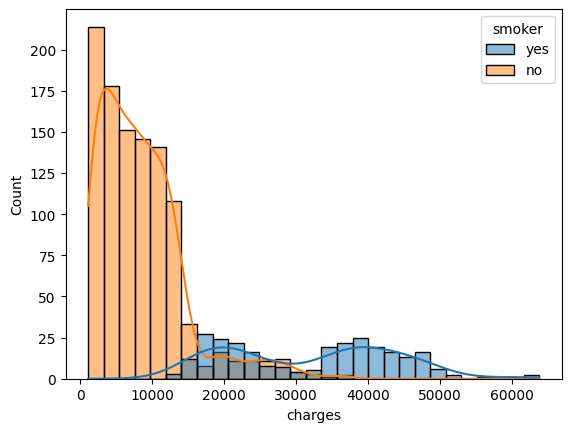

In [180]:
sns.histplot(data = df, x = 'charges', kde=True, hue = 'smoker')

In [181]:
threshold = 19000

df.loc[df['smoker'].isnull() & (df['charges'] > threshold), 'smoker'] = 'yes'
df.loc[df['smoker'].isnull() & (df['charges'] <= threshold), 'smoker'] = 'no'

In [184]:
print(df.isnull().sum())

age         12
sex         19
bmi         17
children    52
smoker       0
region       0
charges      0
dtype: int64


From the correlation table, `charges` can be used to determine the `age` column. First we will plot the relation between them.

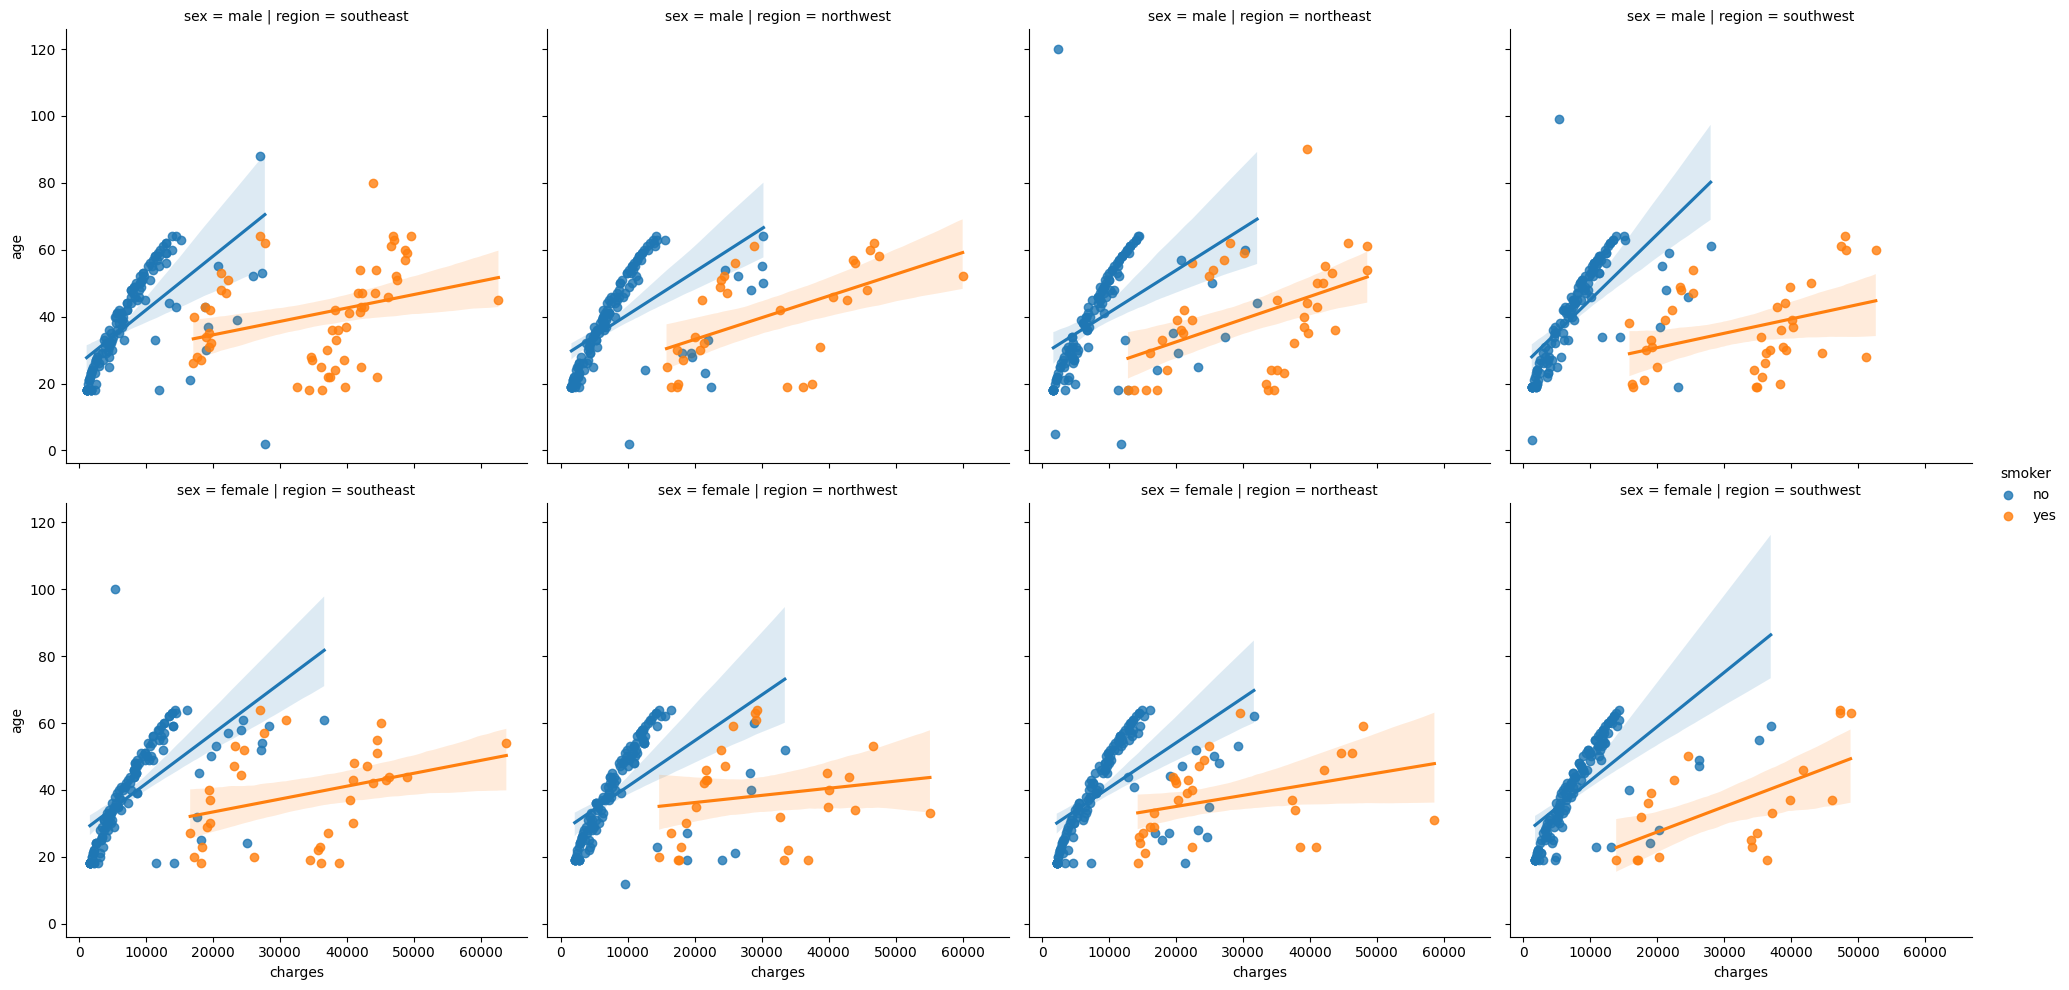

In [213]:
sns.lmplot(x = "charges", y = "age", row = "sex", col = "region", hue = 'smoker', data = df)

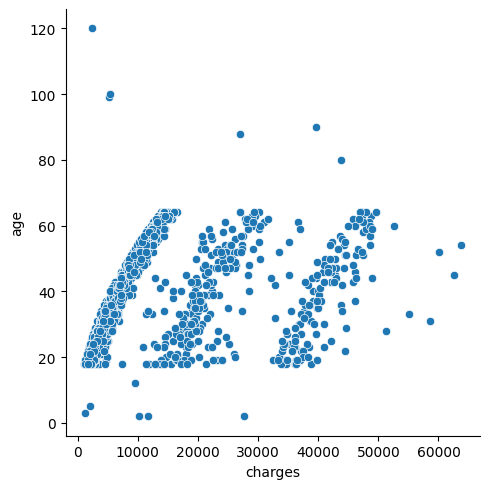

In [185]:
sns.relplot(data = df, x = 'charges', y = 'age')

I will use Kmeans clustering to define the threshold for each region as the med point between the means.

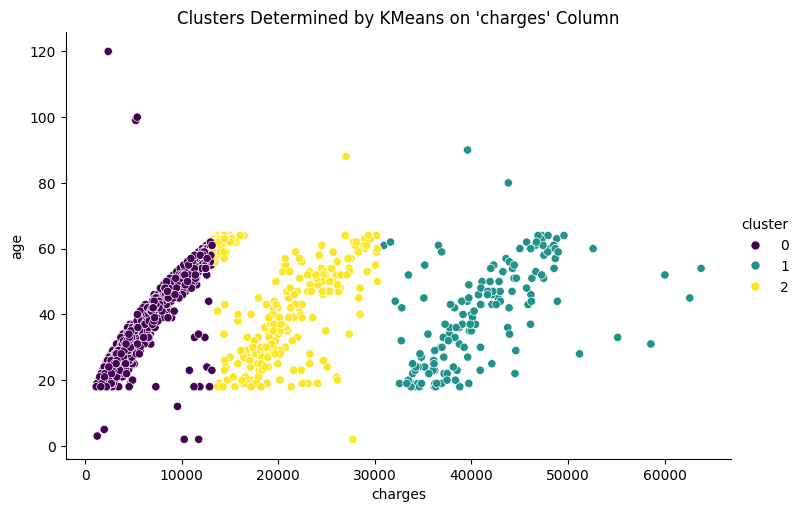

In [186]:

model = KMeans(n_clusters=3, random_state=42, n_init='auto').fit(df[['charges']])
df['cluster'] = model.labels_

sns.relplot(data=df, x='charges', y='age', hue='cluster', palette='viridis', aspect=1.5)

plt.title("Clusters Determined by KMeans on 'charges' Column")
plt.show()

In [187]:
cetners = sorted(model.cluster_centers_.flatten())

threshold1 = (cetners[0] + cetners[1]) / 2
threshold2 = (cetners[1] + cetners[2]) / 2


In [189]:
from sklearn.linear_model import LinearRegression
def fill_nan(df):
    df_missing = df[df['age'].isna()]
    df_not_missing = df[~df['age'].isna()]
    model = LinearRegression()
    model.fit(df_not_missing[['charges']], df_not_missing['age'])

    x_missing = df_missing[['charges']]
    df.loc[df['age'].isna(), 'age'] = model.predict(x_missing)
    return df

In [190]:

df_s1 = df[df['charges'] <= threshold1]
df_s2 = df[(df['charges'] > threshold1) & (df['charges'] <= threshold2)]
df_s3 = df[df['charges'] > threshold2]

df_s1 = fill_nan(df_s1)
df_s2 = fill_nan(df_s2)
df_s3 = fill_nan(df_s3)

df = pd.concat([df_s1, df_s2, df_s3])


In [192]:
print(df.isnull().sum())

age          0
sex         19
bmi         17
children    52
smoker       0
region       0
charges      0
cluster      0
dtype: int64


For `bmi`, we will replace it with the mean of the column and replace `sex` with the mode.

In [193]:
df.loc[df['bmi'].isna(), 'bmi']  = int(df['bmi'].mean())

In [195]:
print(df.isnull().sum())

age          0
sex         19
bmi          0
children    52
smoker       0
region       0
charges      0
cluster      0
dtype: int64


In [196]:
df.loc[df['sex'].isnull(), 'sex'] = df['sex'].mode().iloc[0]

In [197]:
print(df.isnull().sum())

age          0
sex          0
bmi          0
children    52
smoker       0
region       0
charges      0
cluster      0
dtype: int64


In [206]:
pd.DataFrame(imputed_data, columns=df_copy.columns)

age     bmi  children      charges  cluster  sex_encoded  \
0     18.0  33.770       1.0   1725.55230      0.0          1.0   
1     28.0  33.000       3.0   4449.46200      0.0          1.0   
2     32.0  28.880       0.0   3866.85520      0.0          1.0   
3     31.0  25.740       0.0   3756.62160      0.0          0.0   
4     46.0  33.440       1.0   8240.58960      0.0          0.0   
...    ...     ...       ...          ...      ...          ...   
1333  62.0  30.875       3.0  46718.16325      1.0          1.0   
1334  43.0  27.800       0.0  37829.72420      1.0          1.0   
1335  25.0  30.200       0.0  33900.65300      1.0          0.0   
1336  19.0  34.700       2.0  36397.57600      1.0          0.0   
1337  42.0  40.370       1.6  43896.37630      1.0          0.0   

      smoker_encoded  region_encoded  
0                0.0             2.0  
1                0.0             2.0  
2                0.0             1.0  
3                0.0             2.0  
4                0.0             2.0  
...              ...             ...  
1333             1.0             1.0  
1334             1.0             3.0  
1335             1.0             3.0  
1336             1.0             3.0  
1337             1.0             2.0  

[1338 rows x 8 columns]

For `children`, I will use KNN to handle the missing data.
[KNNImputer](https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/)


In [207]:
from sklearn.impute import KNNImputer

df_copy = df.copy()

label_encoder = LabelEncoder()

df_copy['sex_encoded'] = label_encoder.fit_transform(df_copy['sex'])
df_copy['smoker_encoded'] = label_encoder.fit_transform(df_copy['smoker'])
df_copy['region_encoded'] = label_encoder.fit_transform(df_copy['region'])

df_copy.drop(['sex','smoker', 'region'],axis=1,inplace=True)

imputer = KNNImputer(n_neighbors=1)  
df_filled = imputer.fit_transform(df_copy)

df_imputed = pd.DataFrame(df_filled, columns=df_copy.columns)

df['children'] = df_imputed['children']


In [208]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
cluster     0
dtype: int64
